# 1. Load Dataset

In [1]:
import gzip
import json
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load data
DIR = '/content/drive/My Drive/Colab Notebooks/Insight_project/data'

def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [4]:
head = None
    
fantasy_books = load_data(os.path.join(DIR, 'goodreads_books_fantasy_paranormal.json.gz'),head)
df = pd.DataFrame(fantasy_books)

In [5]:
# Drop unnecessary rows
to_drop = ['popular_shelves','isbn','isbn13','asin',\
           'kindle_asin','link','edition_information','title_without_series']
df.drop(columns=to_drop,inplace=True)

In [6]:
# Manipulatet the dataframe
df.loc[:, 'series'] = df.series.map(lambda x: len(x)!=0)

def get_author_id(x):
    if len(x)>0:
        return x[0]['author_id']
    else:
        return ''

df.loc[:, 'authors'] = df.authors.map(lambda x: get_author_id(x))
df.loc[:,'is_ebook'] = df.is_ebook.map(lambda x: x == 'true')

In [7]:
# cast columns to the correct types
df.text_reviews_count = df.text_reviews_count.astype(int)
df.average_rating = df.average_rating.astype(float)
df.ratings_count = df.ratings_count.astype(int)
df.book_id = df.book_id.astype(int)
df.work_id = df.work_id.astype(int)

In [8]:
# Manipulatet the dataframe
def handle_missing_number(x):
    if not x: # empty strings are false
        return None # np.nan; # float('NaN')
    else:
        return int(x)

df.loc[:,'num_pages'] = df.num_pages.map(lambda x: handle_missing_number(x))
df.loc[:,'publication_day'] = df.publication_day.map(lambda x: handle_missing_number(x))
df.loc[:,'publication_year'] = df.publication_year.map(lambda x: handle_missing_number(x))

In [9]:
# cast columns to the correct types
df.publication_month = df.publication_month.astype('category')
df.country_code = df.country_code.astype('category')
df.language_code = df.language_code.astype('category')
df.format = df.format.astype('category')
df.publisher = df.publisher.astype('category')

df.description = df.description.astype('string')
df.title = df.title.astype('string')

In [10]:
# Add author information to the books
authors = load_data(os.path.join(DIR, 'goodreads_book_authors.json.gz'),head)

In [11]:
authors = pd.DataFrame(authors)
authors = authors.set_index('author_id')

In [12]:
def get_author_name(x):
  if x != '':
    try:
      author = authors.iloc[int(x)]
      return author[2]
    except:
      return ''
  else:
    return ''

def get_author_rating(x):
  if x != '':
    try:
      author = authors.iloc[int(x)]
      return float(author[0])
    except:
      return 4 # average author rating value
  else:
    return 4

def get_author_ratings_count(x):
  if x != '':
    try:
      author = authors.iloc[int(x)]
      return int(author[3])
    except:
      return 0
  else:
    return 0

df['author_name'] = df.authors.map(lambda x: get_author_name(x))
df['author_rating'] = df.authors.map(lambda x: get_author_rating(x))
df['author_ratings_count'] = df.authors.map(lambda x: get_author_ratings_count(x))

# 2. Clean Dataset

In [13]:
# Get rid of infinity values
df["ratings_count_logged"] = np.log(df["ratings_count"])
df["author_ratings_count_logged"] = np.log(df["author_ratings_count"])
def handle_infinity(x):
    if math.isinf(x):
        return 0 # np.nan
    else:
        return x
df.loc[:,'ratings_count_logged'] = df.ratings_count_logged.map(lambda x: handle_infinity(x))
df.loc[:,'author_ratings_count_logged'] = df.author_ratings_count_logged.map(lambda x: handle_infinity(x))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
# Get rid of books with no synopsis data and convert to lowercase
df = df[df.description != '']
df['description'] = df.description.str.lower()

# Restrict data to only English books
df = df[df.language_code.str.contains('en')]

In [15]:
# Remove newline and tab tokens
df['description'] = df['description'].apply(lambda x: x.replace("\n", " "))
df['description'] = df['description'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [16]:
# Drop rows that don't meet the criteria
df = df[df.num_pages > 0]
df = df[df.publication_year >= 2000]
df = df[df.publication_year <= 2017]
df = df[df.ratings_count >= 0]

In [17]:
# Assign popularity labels using the median rating count as the cutoff
qcut_label = ['Low','High']
df['ratings_count_logged_bin'] = pd.qcut(df['ratings_count_logged'],q=2,labels=qcut_label)

In [18]:
labels = df['ratings_count_logged_bin']=="High"
df['labels'] = labels

# 3. Exploratory Data Analysis

In [19]:
df.groupby('is_ebook').count()

,text_reviews_count,series,country_code,language_code,average_rating,similar_books,description,format,authors,publisher,num_pages,publication_day,publication_month,publication_year,url,image_url,book_id,ratings_count,work_id,title,author_name,author_rating,author_ratings_count,ratings_count_logged,author_ratings_count_logged,ratings_count_logged_bin,labels
is_ebook,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,44518,44518,44518,44518,44518,44518,44518,44518,44518,44518,44518,39661,44518,44518,44518,44518,44518,44518,44518,44518,44518,44518,44518,44518,44518,44518,44518
True,39217,39217,39217,39217,39217,39217,39217,39217,39217,39217,39217,36544,39217,39217,39217,39217,39217,39217,39217,39217,39217,39217,39217,39217,39217,39217,39217


In [20]:
df.groupby('format').count()

,text_reviews_count,series,country_code,language_code,is_ebook,average_rating,similar_books,description,authors,publisher,num_pages,publication_day,publication_month,publication_year,url,image_url,book_id,ratings_count,work_id,title,author_name,author_rating,author_ratings_count,ratings_count_logged,author_ratings_count_logged,ratings_count_logged_bin,labels
format,,,,,,,,,,,,,,,,,,,,,,,,,,,
,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4663,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998
3-ring Binder,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6 x 9 softcover; PDF (available seperately or bundled),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"8.5&quot; x 7&quot; (half legal), B&amp;W, Saddle Stapled",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A4 Paper,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
softcover,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
trade Paperback,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
trade paperback,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [21]:
df.groupby('country_code').count()

,text_reviews_count,series,language_code,is_ebook,average_rating,similar_books,description,format,authors,publisher,num_pages,publication_day,publication_month,publication_year,url,image_url,book_id,ratings_count,work_id,title,author_name,author_rating,author_ratings_count,ratings_count_logged,author_ratings_count_logged,ratings_count_logged_bin,labels
country_code,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,83735,83735,83735,83735,83735,83735,83735,83735,83735,83735,83735,76205,83735,83735,83735,83735,83735,83735,83735,83735,83735,83735,83735,83735,83735,83735,83735


In [22]:
df.groupby('language_code').count()

,text_reviews_count,series,country_code,is_ebook,average_rating,similar_books,description,format,authors,publisher,num_pages,publication_day,publication_month,publication_year,url,image_url,book_id,ratings_count,work_id,title,author_name,author_rating,author_ratings_count,ratings_count_logged,author_ratings_count_logged,ratings_count_logged_bin,labels
language_code,,,,,,,,,,,,,,,,,,,,,,,,,,,
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
--,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ukr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
urd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
vie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


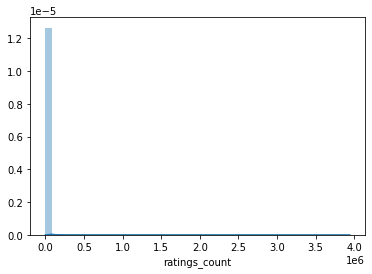

In [23]:
sns.distplot(df["ratings_count"].dropna());

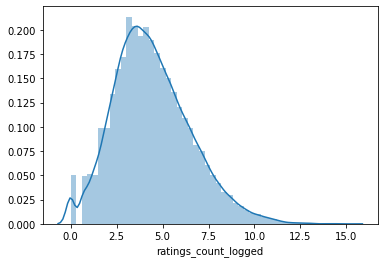

In [24]:
sns.distplot(df["ratings_count_logged"].dropna());

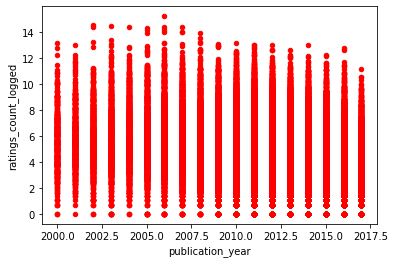

In [25]:
df.plot(kind='scatter',x='publication_year',y='ratings_count_logged',color='red')

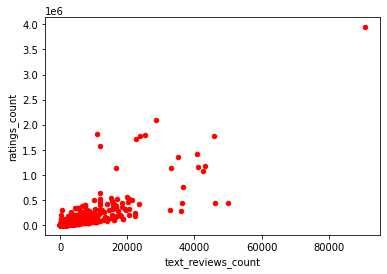

In [26]:
df.plot(kind='scatter',x='text_reviews_count',y='ratings_count',color='red')

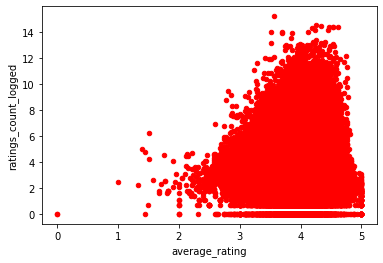

In [27]:
df.plot(kind='scatter',x='average_rating',y='ratings_count_logged',color='red')

# 4. Save Data

In [28]:
# Drop columns that are not used
df = df[['author_name','author_rating','description','image_url','labels',
         'num_pages','publication_year','publisher','series','title']]

In [29]:
# Renumber rows
df = df.reset_index(drop=True)

In [30]:
# Visualize table
df

,author_name,author_rating,description,image_url,labels,num_pages,publication_year,publisher,series,title
0,,4.00,marius believes himself to be an ordinary smal...,https://images.gr-assets.com/books/1416947877m...,True,279.0,2014.0,Amy Raby,True,"Healer's Touch (Hearts And Thrones, #4)"
1,,4.00,this contains all six novels and two shorts of...,https://images.gr-assets.com/books/1380976538m...,False,2969.0,2013.0,Vamptasy Publishing,True,The Blood and Light Series (Blood and Light #1-6)
2,Katharine Boling,3.71,"an unflinching, darkly funny, and deeply movin...",https://images.gr-assets.com/books/1421247398m...,False,240.0,2012.0,Walker Childrens Hardbacks,False,A Monster Calls
3,Ou-Yang Chow Lin,4.54,asian-american superheroines evie tanaka and a...,https://images.gr-assets.com/books/1493515355m...,False,384.0,2017.0,Daw Books,True,"Heroine Worship (Heroine Complex, #2)"
4,L.T. Vargus,3.93,volume one of clive barker's seminal books of ...,https://images.gr-assets.com/books/1464920423m...,False,213.0,2015.0,"Little, Brown Book Group",True,Books of Blood 1 (Books of Blood #1)
...,...,...,...,...,...,...,...,...,...,...
83730,,4.00,librarian's note: alternate cover edition of a...,https://images.gr-assets.com/books/1433608029m...,False,342.0,2015.0,"Twelve Oakes Publishing, Inc.",True,"My Soul To Wake (Stain, #1)"
83731,Zena Kouphopoulou,4.00,"the ghost of sherlock holmes is dead, but who ...",https://s.gr-assets.com/assets/nophoto/book/11...,True,358.0,2017.0,Pan Macmillan,True,Who Killed Sherlock Holmes?
83732,Gordon Sager,4.50,"a man she'd die for, a world she was born to d...",https://images.gr-assets.com/books/1373995821m...,False,362.0,2013.0,Samhain Publishing,True,"Soul Chase (Dark Souls, #3)"
83733,,4.00,"in the city that never sleeps, spirits are equ...",https://images.gr-assets.com/books/1413258573m...,False,219.0,2014.0,Chromatic Press,False,Dead Endings


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83735 entries, 0 to 83734
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   author_name       83735 non-null  object  
 1   author_rating     83735 non-null  float64 
 2   description       83735 non-null  object  
 3   image_url         83735 non-null  object  
 4   labels            83735 non-null  bool    
 5   num_pages         83735 non-null  float64 
 6   publication_year  83735 non-null  float64 
 7   publisher         83735 non-null  category
 8   series            83735 non-null  bool    
 9   title             83735 non-null  string  
dtypes: bool(2), category(1), float64(3), object(3), string(1)
memory usage: 6.2+ MB


In [32]:
df.describe()

,author_rating,num_pages,publication_year
count,83735.000000,83735.000000,83735.000000
mean,3.963467,287.703565,2012.044306
std,0.271153,353.008146,3.348675
min,0.000000,1.000000,2000.000000
25%,4.000000,174.000000,2011.000000
50%,4.000000,287.000000,2013.000000
75%,4.000000,370.000000,2014.000000
max,5.000000,82000.000000,2017.000000


In [33]:
# Save dataframe
pickle.dump(df,open('/content/drive/My Drive/Colab Notebooks/Insight_project/data/df.sav','wb'))